In [74]:
from IPython import get_ipython
get_ipython().run_line_magic("reset","-f")

from PyPackageJonas import *

figures_path = "C:/Users/jonas/Git/Analysis-of-Production-flow-systems-with-focus-on-industry/Latex Thesis/figures/"


In [75]:
rho = 0.5
data = scipy.stats.multivariate_normal.rvs(mean = None, cov = np.array([[1,rho],[rho,1]]), size = 300)

data.var(axis = 0)

array([1.03116851, 1.02983045])

In [76]:
X = data[:,0]
Y = data[:,1]


X = scipy.stats.ecdf(X).cdf.evaluate(X) - 1 / 2 / X.__len__()       # Correct such that equally dist at top and buttom
Y = scipy.stats.ecdf(Y).cdf.evaluate(Y) - 1 / 2 / X.__len__()

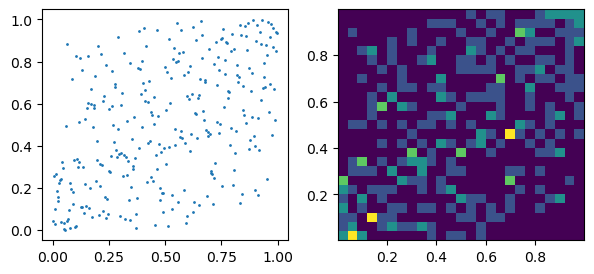

In [77]:
fig, ax = plt.subplots(1,2, figsize = (7,3))
ax[0].scatter(X,Y, s = 1)
ax[1].hist2d(X,Y, 25);

In [78]:
# h = 100**(-1/5) * np.vstack([X,Y]).var(axis = 1)**0.5
# h

In [79]:
# Generate kernel (takes some time to compute normalization constant -> checked later that sum is approx 1)
# kern_nn = KernelJones2D_nonnegative(np.vstack([X,Y]))
kern_centers = np.vstack([X,Y])
kern_nn = KernelJones2D_nonnegative_version_Jonas(
    kern_centers,
    kern_centers.shape[1]**(-1/5) * kern_centers.var(axis = 1)**0.5
)

Computing normalization constants...

In [80]:
# Generate mesh to evaluate on
x_lin = np.linspace(0,1,701) #; x_lin = (x_lin[1:] + x_lin[:-1]) / 2
y_lin = np.linspace(0,1,701) #; y_lin = (y_lin[1:] + y_lin[:-1]) / 2
xx, yy = np.meshgrid(x_lin, y_lin)

In [81]:
res_nn = kern_nn(np.array([xx.flatten(), yy.flatten()]))
print(f"prob mass : {res_nn.mean()}")

prob mass : 1.0217531831258275


In [82]:
c_new = res_nn.mean()

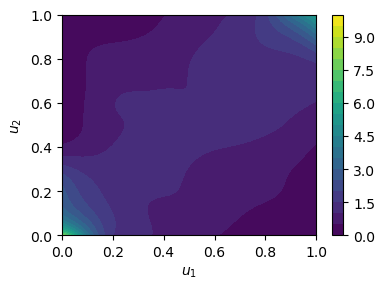

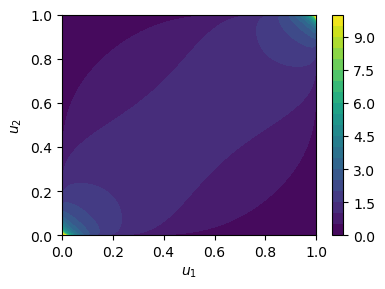

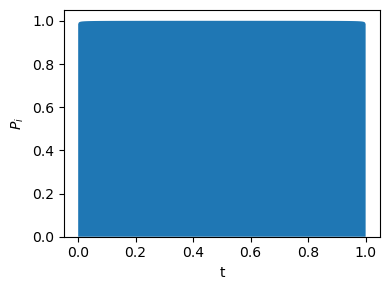

In [89]:
z_nn = res_nn.copy() / c_new
z_nn = np.reshape(z_nn, xx.shape)

gaus_copula = gen_gaus_c(rho)
xx_c, yy_c = np.meshgrid(np.linspace(0+6e-4,1-6e-4,1500), np.linspace(0+0+6e-4,1-6e-4,1500))
z_c = gaus_copula(xx_c,yy_c)


levels_u = np.min([z_nn.max(), z_c.max(), 24])
levels_u = ((levels_u // 2) // 1 + 1 ) * 2
levels = np.linspace(0, levels_u, 21 )

fig, ax = plt.subplots(1,1, figsize = (4,3))
a = ax.contourf(xx, yy, z_nn, levels=levels)
cbar = plt.colorbar(a)
# ax.set_title("empirical copula")
ax.set_xlabel(r"$u_1$")
ax.set_ylabel(r"$u_2$")
fig.tight_layout()

# plt.savefig(figures_path + "MI estimation/regularized Jones - rho 0.5.pdf", bbox_inches='tight')
# plt.savefig(figures_path + "MI estimation/regularized Jones - rho 0.5.png", bbox_inches='tight')






fig, ax = plt.subplots(1,1, figsize = (4,3))
a = ax.contourf(xx_c, yy_c, z_c, levels=levels)
plt.colorbar(a)
plt.xlim([0,1])
plt.ylim([0,1]);
ax.set_xlabel(r"$u_1$")
ax.set_ylabel(r"$u_2$")
fig.tight_layout()
# ax.set_title("theoretical copula");

# plt.savefig(figures_path + "MI estimation/theoretical gaussian copula - rho 0.9.pdf", bbox_inches='tight')
# plt.savefig(figures_path + "MI estimation/theoretical gaussian copula - rho 0.9.png", bbox_inches='tight')



res = z_c.mean(axis = 0)
res = (res[1:] + res[:-1]) / 2
fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.stairs(res, np.linspace(0,1,res.__len__() + 1), fill=True)
# ax.vlines(np.linspace(0,1,res.__len__()+1), 0, res.max(), colors='w')
ax.set_xlabel("t")
ax.set_ylabel(r"$P_i$")
# ax.set_xticks(np.linspace(1,n_bins, n_bins) / n_bins - 1 / (2 * n_bins))
# ax.set_xticklabels([i+1 for i in range(n_bins)])
fig.tight_layout()


# for small rho, much closer to uniform marginals than large rho. Might want to non-netivize and re-normalize each kernel

In [84]:
# raw
# Hxy = - (z_nn  * np.log(z_nn)).mean()
# Hx  = - (z_nn.mean(axis = 0) * np.log(z_nn.mean(axis = 0))).mean()
# Hy  = - (z_nn.mean(axis = 1) * np.log(z_nn.mean(axis = 1))).mean()
# print(f"{Hx} + {Hy} - {Hxy} = {Hx + Hy - Hxy}")



# Trapez est.
Trapz_weights_2d = np.array([[1] + [2 for i in range(z_nn.shape[1]-2)] + [1]] + 
                             [[2] + [4 for i in range(z_nn.shape[1]-2)] + [2] for j in range(z_nn.shape[0] - 2)] + 
                             [[1] + [2 for i in range(z_nn.shape[1]-2)] + [1]] )
c_xy = (z_nn * Trapz_weights_2d).sum() / 4 / np.prod([z_nn.shape[0] - 1 , z_nn.shape[1] - 1])
Hxy = - (z_nn * np.log(z_nn) * Trapz_weights_2d).sum() / 4 / np.prod([z_nn.shape[0] - 1 , z_nn.shape[1] - 1])

Trapez_weights_1d = np.array([1] + [2 for i in range(z_nn.shape[0] - 2)] + [1])
c_x = (z_nn.mean(axis = 1) * Trapez_weights_1d).sum() / 2 / (z_nn.shape[0]-1)
Hx = - (z_nn.mean(axis = 1) * np.log(z_nn.mean(axis = 1)) * Trapez_weights_1d).sum() / 2 / (z_nn.shape[0]-1)

Trapez_weights_1d = np.array([1] + [2 for i in range(z_nn.shape[1] - 2)] + [1])
c_y = (z_nn.mean(axis = 0) * Trapez_weights_1d).sum() / 2 / (z_nn.shape[1] - 1)
Hy = - (z_nn.mean(axis = 0) * np.log(z_nn.mean(axis = 0)) * Trapez_weights_1d).sum() / 2 / (z_nn.shape[1] - 1)

# correct for weights
Hx = (Hx - np.log(c_x)) / c_x
Hy = (Hy - np.log(c_y)) / c_y
Hxy = (Hxy - np.log(c_xy)) / c_xy

print(f"{Hx} + {Hy} - {Hxy} = {Hx + Hy - Hxy}")




# Simpson set.
Simpsonweights_2d = np.array([[1] + [2* ((i+1)%2) + 2 for i in range(z_nn.shape[1]-2)] + [1]] + 
                             [[2 * ((j+1)%2) + 2] + [(2* ((i+1)%2) + 2) * (2 * ((j+1)%2) + 2) for i in range(z_nn.shape[1]-2)] + [2 * ((j+1)%2) + 2] for j in range(z_nn.shape[0]-2)] + 
                             [[1] + [2* ((i+1)%2) + 2 for i in range(z_nn.shape[1]-2)] + [1]] )
c_xy = (z_nn * Simpsonweights_2d).sum() / 9 / np.prod([z_nn.shape[0] - 1 , z_nn.shape[1] - 1])
Hxy = - (z_nn * np.log(z_nn) * Simpsonweights_2d).sum() / 9 / np.prod([z_nn.shape[0] - 1 , z_nn.shape[1] - 1])

Simpsonweights_1d = np.array([1] + [2* ((i+1)%2) + 2 for i in range(z_nn.shape[0] - 2)] + [1])
c_x = (z_nn.mean(axis = 1) * Simpsonweights_1d).sum() / 3 / (z_nn.shape[0]-1)
Hx = - (z_nn.mean(axis = 1) * np.log(z_nn.mean(axis = 1)) * Simpsonweights_1d).sum() / 3 / (z_nn.shape[0]-1)

Simpsonweights_1d = np.array([1] + [2* ((i+1)%2) + 2 for i in range(z_nn.shape[1] - 2)] + [1])
c_y = (z_nn.mean(axis = 0) * Simpsonweights_1d).sum() / 3 / (z_nn.shape[1] - 1)
Hy = - (z_nn.mean(axis = 0) * np.log(z_nn.mean(axis = 0)) * Simpsonweights_1d).sum() / 3 / (z_nn.shape[1]-1)

# correct for weights
Hx = (Hx - np.log(c_x)) / c_x
Hy = (Hy - np.log(c_y)) / c_y
Hxy = (Hxy - np.log(c_xy)) / c_xy

print(f"{Hx} + {Hy} - {Hxy} = {Hx + Hy - Hxy}")




print(f"theoretical MI : {-0.5 * np.log( 1 - rho**2)}")


# rho = 0.95 - true MI = 1.1639514504891677 - using 700x700 grid - probability mass is not 1 anymore - correcting for extra mass around 21 - 24
# runs:
    # 72.93643097088923
    # 47.373618075280035
    # 58.424153422937415
# increasing the number density of mesh seems to get more accurate results but still not close





# rho = 0.9 - true MI = 0.8303656034108255 - using 500x500 grid
# runs:
    # 0.771305692312177
    # 0.7160725163449495
    # 0.7015484781230266
    # 0.7586075238740865
    # 0.7514862622065581
    # 0.6293326115112262
    # 0.6762494918225319

# rho = 0.9 - true MI = 0.8303656034108255 - using 700x700 grid
# runs:
    # 0.6953513129241953
    # 1.0449855468953293
    # 0.6864321660179645
    # 0.9863725725648258
    # 





# rho = 0.5 - true MI = 0.14384103622589045 - using 700x700grid
# runs using wrong formula :((:
    # 0.16759313090746544
    # 0.13303523637042428
    # 0.15237370288786833
    # 0.1639709402127958
    # 0.21079069407706263
    # 0.1718386132601093
    # 0.228978809221221
# runs using the correct formula :(
    # 0.17701221853502314
    # 0.17947677141701932
    # 0.14395840549990835
    # 0.12253432656735835
    # 0.15624692951574992
    # 0.14836583766741554
    # 0.13452058261687702
    # 0.13787030661529773
    # 0.1562510723508732
    # 0.15381115644310786
    # 0.1717448720720293
# runs using center points instead of edges: (want less than theoretical)
    # 0.154019880485063
    # 0.18973397258966954
    # 0.19830792949351805
    # 0.2071606312323414
    # 0.1690216336754641
    # 0.1262147630773271
    # 0.18244154238367982
    # 0.1284536651794335
    # 0.17385746452999024



-0.000889182680454909 + -0.0008022596417719892 - -0.15833966263298838 = 0.15664822031076148
-0.0008860796209182772 + -0.0008002931444841895 - -0.15832936640394596 = 0.1566429936385435
theoretical MI : 0.14384103622589045


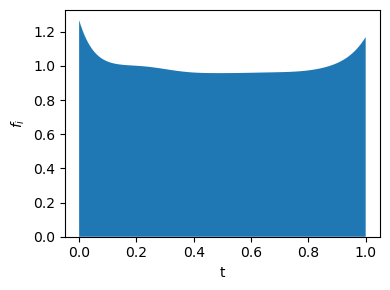

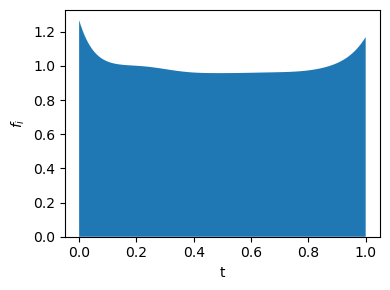

In [85]:
# u_0
marginal_1 = z_nn.mean(axis = 1)
marginal_1_centers = (marginal_1[1:] + marginal_1[:-1]) / 2

fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.stairs(marginal_1_centers, np.linspace(0,1,marginal_1_centers.__len__() + 1), fill=True)
ax.set_xlabel("t")
ax.set_ylabel(r"$f_i$")
fig.tight_layout()

# plt.savefig(figures_path + "MI estimation/Bad MI estimate var 1 - corrected method - k = 1", bbox_inches='tight')



# u_1
marginal_2 = z_nn.mean(axis = 1)
marginal_2_centers = (marginal_2[1:] + marginal_2[:-1]) / 2

fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.stairs(marginal_2_centers, np.linspace(0,1,marginal_2_centers.__len__() + 1), fill=True)
ax.set_xlabel("t")
ax.set_ylabel(r"$f_i$")
fig.tight_layout()

In [86]:
# correction for probability mass
# print(f"{Hx/c_new + Hy/c_new - Hxy/c_new  - 1/c_new * np.log(c_new)}")

In [87]:
# variance of each component is 1/12 (is uniform dist.)

# grund til copula er hvis man senere vil bruge non-parametric network, så skal man bruge copula, så god est. af fordeling er vigtig

# Problem er peaks for høje rho, som med samme h ikke bliver lige godt repræsenteret

In [88]:


# for small rho, much closer to uniform marginals than large rho. Might want to non-negativize and re-normalize each kernel